## Unsupervised Autoencoder Anomaly Detection

1. Train an autoencoder to capture latent representation of entire dataset
2. Extract the latent representation of the entire dataset
3. Append the reconstruction error as part of the feature vector for the latent representation dataset
4. Perform clustering against the new dataset to determine natural groupings
5. Train another autoencoder against datapoints within groupings treated as normal
6. Apply autothresholding with head tail break
7. Test performance

In [1]:
import sys
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import iqr
from matplotlib import pyplot

# Local imports
sys.path.append('..')

from lib.autoencoder import Autoencoder
from lib.autoencoder_dataset import AutoencoderDataset

## Experimental Parameters

In [2]:
# Label column
label_column = 'y'

ds_train_file = "../Datasets/thyroid_train.csv"
ds_test_file = "../Datasets/thyroid_test.csv"

# Dataframe instance for training data
df_train = pd.read_csv(ds_train_file)
# Dataframe instance for test data
df_test = pd.read_csv(ds_test_file)

# Expected number of features
n_features = 21

# Extracted dataframe for all training values without labels
df_train_x = df_train.drop([label_column], axis=1)
# Extracted dataframe for all labels of training data
df_train_y = df_train[label_column]

# Extracted dataframe for all test values without labels
df_test_x = df_test.drop(['y'], axis=1)
# Extracted dataframe for all test labels of testing data
df_test_y = df_test['y']

# Autoencoder parameter for layers. First element is the size of the input vector. Succeeding values are hidden layers for the encoder
layers = [21, 12]

# Autoencoder parameter for hidden activation
h_activation = 'relu'

# Autoencoder parameter for output activation
o_activation = 'sigmoid'

# Autoencoder parameter for learning rate
learning_rate = 0.000001

# Torch parameter for device
device = 'cpu'

# Training parameter for number of epochs
epochs = 100

# Training parameter for batch size
batch_size = 10

# Loss function
loss_fn = nn.MSELoss()

# DBSCAN parameter eps
eps = 0.04

# DBSCAN parameter minimum samples
min_samples = 5

## Train Autoencoder Model

The first autoencoder will attempt to get the latent representation of the data regardless of the labels.

In [3]:
model = Autoencoder(layers=layers, h_activation=h_activation, o_activation=o_activation, device=device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Represent the training data as x
x = torch.tensor(df_train_x.values).float().to(device)

# Load the dataset
train_ds = AutoencoderDataset(x=x)

# Create a DataLoader instance
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, drop_last=False)

# The training process
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    loop = tqdm(train_loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Feed forward
        predictions = model(data)
        
        loss = loss_fn(predictions, targets)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update tqdm
        loop.set_postfix(loss=loss.item())
        
print("Done training!")

Epoch: 0


  0%|                                                                                                                                                                                      | 0/378 [00:00<?, ?it/s]/home/ralampay/workspace/notebooks/env/lib/python3.9/site-packages/torch/autograd/__init__.py:154: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 392.47it/s, loss=0.233]


Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 359.26it/s, loss=0.232]


Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 390.28it/s, loss=0.232]


Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 391.77it/s, loss=0.232]


Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 389.46it/s, loss=0.232]


Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 386.61it/s, loss=0.232]


Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 399.85it/s, loss=0.231]


Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 403.49it/s, loss=0.231]


Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 401.84it/s, loss=0.231]


Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 396.41it/s, loss=0.231]


Epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 392.81it/s, loss=0.23]


Epoch: 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 406.00it/s, loss=0.23]


Epoch: 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 387.50it/s, loss=0.23]


Epoch: 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 407.44it/s, loss=0.23]


Epoch: 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 400.84it/s, loss=0.23]


Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 401.01it/s, loss=0.229]


Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 396.76it/s, loss=0.229]


Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 382.57it/s, loss=0.229]


Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 398.14it/s, loss=0.229]


Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 376.75it/s, loss=0.228]


Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 403.37it/s, loss=0.228]


Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 393.90it/s, loss=0.228]


Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 401.04it/s, loss=0.228]


Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 388.60it/s, loss=0.228]


Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 394.60it/s, loss=0.227]


Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 401.55it/s, loss=0.227]


Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 402.07it/s, loss=0.227]


Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 389.00it/s, loss=0.227]


Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 402.44it/s, loss=0.227]


Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 405.18it/s, loss=0.226]


Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 393.04it/s, loss=0.226]


Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 414.46it/s, loss=0.226]


Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 413.67it/s, loss=0.226]


Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 384.68it/s, loss=0.226]


Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 397.24it/s, loss=0.225]


Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 404.77it/s, loss=0.225]


Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 401.20it/s, loss=0.225]


Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 376.60it/s, loss=0.225]


Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 394.50it/s, loss=0.224]


Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 404.12it/s, loss=0.224]


Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 406.75it/s, loss=0.224]


Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 404.04it/s, loss=0.224]


Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 393.00it/s, loss=0.224]


Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 365.48it/s, loss=0.223]


Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 408.31it/s, loss=0.223]


Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 393.36it/s, loss=0.223]


Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 388.01it/s, loss=0.223]


Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 396.53it/s, loss=0.223]


Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 398.03it/s, loss=0.222]


Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 387.32it/s, loss=0.222]


Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 377.55it/s, loss=0.222]


Epoch: 51


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 375.10it/s, loss=0.222]


Epoch: 52


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 356.13it/s, loss=0.222]


Epoch: 53


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 445.16it/s, loss=0.221]


Epoch: 54


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 513.90it/s, loss=0.221]


Epoch: 55


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 352.76it/s, loss=0.221]


Epoch: 56


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 364.93it/s, loss=0.221]


Epoch: 57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 392.18it/s, loss=0.22]


Epoch: 58


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 395.37it/s, loss=0.22]


Epoch: 59


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 398.98it/s, loss=0.22]


Epoch: 60


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 354.40it/s, loss=0.22]


Epoch: 61


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 381.56it/s, loss=0.22]


Epoch: 62


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 378.07it/s, loss=0.219]


Epoch: 63


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 376.61it/s, loss=0.219]


Epoch: 64


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 396.97it/s, loss=0.219]


Epoch: 65


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 393.60it/s, loss=0.219]


Epoch: 66


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 389.79it/s, loss=0.219]


Epoch: 67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 373.76it/s, loss=0.218]


Epoch: 68


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 375.75it/s, loss=0.218]


Epoch: 69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 392.41it/s, loss=0.218]


Epoch: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 376.20it/s, loss=0.218]


Epoch: 71


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 403.38it/s, loss=0.218]


Epoch: 72


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 386.97it/s, loss=0.217]


Epoch: 73


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 393.06it/s, loss=0.217]


Epoch: 74


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 365.68it/s, loss=0.217]


Epoch: 75


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 378.47it/s, loss=0.217]


Epoch: 76


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 386.78it/s, loss=0.217]


Epoch: 77


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 371.90it/s, loss=0.216]


Epoch: 78


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 377.76it/s, loss=0.216]


Epoch: 79


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 391.08it/s, loss=0.216]


Epoch: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 353.70it/s, loss=0.216]


Epoch: 81


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 375.17it/s, loss=0.216]


Epoch: 82


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 392.57it/s, loss=0.215]


Epoch: 83


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 365.47it/s, loss=0.215]


Epoch: 84


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 384.53it/s, loss=0.215]


Epoch: 85


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 381.03it/s, loss=0.215]


Epoch: 86


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 378.31it/s, loss=0.214]


Epoch: 87


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 371.42it/s, loss=0.214]


Epoch: 88


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 370.93it/s, loss=0.214]


Epoch: 89


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 375.61it/s, loss=0.214]


Epoch: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 369.67it/s, loss=0.214]


Epoch: 91


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 369.96it/s, loss=0.213]


Epoch: 92


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 385.97it/s, loss=0.213]


Epoch: 93


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 379.74it/s, loss=0.213]


Epoch: 94


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 389.64it/s, loss=0.213]


Epoch: 95


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 363.76it/s, loss=0.213]


Epoch: 96


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 366.12it/s, loss=0.212]


Epoch: 97


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 376.00it/s, loss=0.212]


Epoch: 98


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 356.30it/s, loss=0.212]


Epoch: 99


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:01<00:00, 370.01it/s, loss=0.212]

Done training!


## Compression

Using the trained autoencoder, compress the data to latent space and create a new data frame containing latent vectors and reconstruction errors.

In [4]:
z = model.encode(x).detach().cpu().numpy().astype(np.float32)

columns = []

for i in range(len(z[0])):
    columns.append("x{}".format(i))

df_z = pd.DataFrame(z, columns=columns)

# Normalize the data with MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
z_scaled = min_max_scaler.fit_transform(df_z.values)

# Reassign to df_z
df_z = pd.DataFrame(z_scaled, columns=columns)

# Fetch the errors per data
predictions = model(x)
targets = x

x_loss = nn.MSELoss(reduction='none')(predictions, targets).sum(axis=1).detach().cpu().numpy().astype(np.float32)
df_z['error'] = x_loss

df_z

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,error
0,0.0,0.000000,0.477488,0.0,0.465637,0.0,0.283381,0.0,0.000000,0.0,0.259630,0.192655,4.412681
1,0.0,0.000000,0.055446,0.0,0.318654,0.0,0.028987,0.0,0.266043,0.0,0.198179,0.000000,4.425606
2,0.0,0.000000,0.123878,0.0,0.355544,0.0,0.090606,0.0,0.280383,0.0,0.152088,0.000000,4.414049
3,0.0,0.317000,0.415033,0.0,0.523067,0.0,0.429463,0.0,0.226310,0.0,0.188963,0.101788,4.514166
4,0.0,0.000000,0.061116,0.0,0.299348,0.0,0.017698,0.0,0.276835,0.0,0.182661,0.000000,4.437716
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,0.0,0.057264,0.226753,0.0,0.381765,0.0,0.178033,0.0,0.300641,0.0,0.088124,0.000000,4.468402
3768,0.0,0.000000,0.109692,0.0,0.337162,0.0,0.074149,0.0,0.280159,0.0,0.158844,0.000000,4.393254
3769,0.0,0.091889,0.262494,0.0,0.393129,0.0,0.212403,0.0,0.310873,0.0,0.062709,0.000000,4.535409
3770,0.0,0.307529,0.423092,0.0,0.515373,0.0,0.430876,0.0,0.227132,0.0,0.186870,0.107145,4.461905


## Clustering

Given the new dataset containing latent vectors and reconstruction error, we'll then perform clustering to form natural groupings.

In [5]:
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df_z.values)

unique_labels = np.unique(clustering.labels_)

print("Cluster labels: {}".format(unique_labels))

df_z_with_cluster_labels = df_z.copy()
df_z_with_cluster_labels['cluster_label'] = clustering.labels_

for cluster_label in unique_labels:
    count = len(df_z_with_cluster_labels[df_z_with_cluster_labels['cluster_label'] == cluster_label])
    print("Count for Cluster {}: {}".format(cluster_label, count))
    
df_z_with_cluster_labels

Cluster labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28]
Count for Cluster -1: 568
Count for Cluster 0: 1552
Count for Cluster 1: 772
Count for Cluster 2: 264
Count for Cluster 3: 56
Count for Cluster 4: 79
Count for Cluster 5: 34
Count for Cluster 6: 68
Count for Cluster 7: 75
Count for Cluster 8: 15
Count for Cluster 9: 76
Count for Cluster 10: 19
Count for Cluster 11: 28
Count for Cluster 12: 9
Count for Cluster 13: 12
Count for Cluster 14: 7
Count for Cluster 15: 9
Count for Cluster 16: 15
Count for Cluster 17: 42
Count for Cluster 18: 10
Count for Cluster 19: 5
Count for Cluster 20: 6
Count for Cluster 21: 6
Count for Cluster 22: 10
Count for Cluster 23: 4
Count for Cluster 24: 5
Count for Cluster 25: 6
Count for Cluster 26: 8
Count for Cluster 27: 5
Count for Cluster 28: 7


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,error,cluster_label
0,0.0,0.000000,0.477488,0.0,0.465637,0.0,0.283381,0.0,0.000000,0.0,0.259630,0.192655,4.412681,-1
1,0.0,0.000000,0.055446,0.0,0.318654,0.0,0.028987,0.0,0.266043,0.0,0.198179,0.000000,4.425606,0
2,0.0,0.000000,0.123878,0.0,0.355544,0.0,0.090606,0.0,0.280383,0.0,0.152088,0.000000,4.414049,0
3,0.0,0.317000,0.415033,0.0,0.523067,0.0,0.429463,0.0,0.226310,0.0,0.188963,0.101788,4.514166,1
4,0.0,0.000000,0.061116,0.0,0.299348,0.0,0.017698,0.0,0.276835,0.0,0.182661,0.000000,4.437716,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,0.0,0.057264,0.226753,0.0,0.381765,0.0,0.178033,0.0,0.300641,0.0,0.088124,0.000000,4.468402,0
3768,0.0,0.000000,0.109692,0.0,0.337162,0.0,0.074149,0.0,0.280159,0.0,0.158844,0.000000,4.393254,0
3769,0.0,0.091889,0.262494,0.0,0.393129,0.0,0.212403,0.0,0.310873,0.0,0.062709,0.000000,4.535409,0
3770,0.0,0.307529,0.423092,0.0,0.515373,0.0,0.430876,0.0,0.227132,0.0,0.186870,0.107145,4.461905,1


## Visualizing Clusters

Use TSNE to reduce to 3 dimensions for visualization and plotly 3d scatterplot for visualization.

**Documentation:**
* **TSNE:**: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
* **Plotly 3D Scatterplot:**: https://plotly.com/python/3d-scatter-plots/

In [6]:
# Fit a TSNE model with 3 dimensions
# z_embedded = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(df_z.values)

# # Create a new data frame for result of tsne and attach cluster label
# df_z_embedded = pd.DataFrame(z_embedded, columns=['x', 'y', 'z'])
# df_z_embedded['cluster_label'] = df_z_with_cluster_labels['cluster_label']

# # Visualize with 3D scatterplot
# fig = px.scatter_3d(df_z_embedded, x='x', y='y', z='z', color='cluster_label')
# fig.show()

## Training for Perceived Normal Data

We now train a new autoencoder model for data points whose cluster_label is not equal to -1. This will serve as our prediction model for auto-thresholding later on.

In [7]:
df_normal = df_train_x.copy()
df_normal = df_normal[df_z_with_cluster_labels['cluster_label'] != -1]

df_normal

,x0,x1,x2,x4,x5,x6,x7,x8,x9,x10,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00025,0.0300,0.143,0.133,0.108
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00190,0.0240,0.102,0.131,0.078
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00090,0.0170,0.077,0.090,0.085
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00025,0.0260,0.139,0.090,0.153
5,0.69,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00025,0.0160,0.086,0.070,0.123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,0.77,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00006,0.0206,0.125,0.107,0.117
3768,0.41,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00130,0.0250,0.125,0.114,0.109
3769,0.88,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.01300,0.0174,0.123,0.099,0.124
3770,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.00078,0.0206,0.106,0.088,0.121


In [8]:
# Represent the training data as x
x = torch.tensor(df_normal.values).float().to(device)

# Load the dataset
train_ds = AutoencoderDataset(x=x)

# Create a DataLoader instance
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, drop_last=False)

# The training process
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    loop = tqdm(train_loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Feed forward
        predictions = model(data)
        
        loss = loss_fn(predictions, targets)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update tqdm
        loop.set_postfix(loss=loss.item())
        
print("Done training!")

Epoch: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 371.30it/s, loss=0.212]


Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 350.11it/s, loss=0.212]


Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 385.47it/s, loss=0.212]


Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 384.41it/s, loss=0.212]


Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 377.56it/s, loss=0.211]


Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 383.14it/s, loss=0.211]


Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 353.03it/s, loss=0.211]


Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 387.98it/s, loss=0.211]


Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 380.09it/s, loss=0.211]


Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 389.25it/s, loss=0.211]


Epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 359.70it/s, loss=0.21]


Epoch: 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 370.02it/s, loss=0.21]


Epoch: 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 374.68it/s, loss=0.21]


Epoch: 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 384.49it/s, loss=0.21]


Epoch: 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 351.89it/s, loss=0.21]


Epoch: 15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 364.48it/s, loss=0.21]


Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 374.63it/s, loss=0.209]


Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 387.71it/s, loss=0.209]


Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 351.76it/s, loss=0.209]


Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 389.10it/s, loss=0.209]


Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 373.28it/s, loss=0.209]


Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 371.67it/s, loss=0.209]


Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 323.67it/s, loss=0.208]


Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 370.20it/s, loss=0.208]


Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 378.56it/s, loss=0.208]


Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 361.96it/s, loss=0.208]


Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 373.27it/s, loss=0.208]


Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 362.75it/s, loss=0.208]


Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 391.84it/s, loss=0.207]


Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 385.12it/s, loss=0.207]


Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 394.34it/s, loss=0.207]


Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 357.95it/s, loss=0.207]


Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 374.68it/s, loss=0.207]


Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 369.86it/s, loss=0.207]


Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 381.13it/s, loss=0.206]


Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 376.57it/s, loss=0.206]


Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 376.55it/s, loss=0.206]


Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 376.04it/s, loss=0.206]


Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 375.66it/s, loss=0.206]


Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 352.99it/s, loss=0.206]


Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 398.83it/s, loss=0.205]


Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 366.25it/s, loss=0.205]


Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 383.57it/s, loss=0.205]


Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 352.65it/s, loss=0.205]


Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 378.32it/s, loss=0.205]


Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 367.30it/s, loss=0.205]


Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 380.33it/s, loss=0.204]


Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 375.64it/s, loss=0.204]


Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 366.35it/s, loss=0.204]


Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 385.25it/s, loss=0.204]


Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 385.10it/s, loss=0.204]


Epoch: 51


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 366.88it/s, loss=0.204]


Epoch: 52


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 385.07it/s, loss=0.203]


Epoch: 53


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 365.75it/s, loss=0.203]


Epoch: 54


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 377.64it/s, loss=0.203]


Epoch: 55


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 351.81it/s, loss=0.203]


Epoch: 56


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 371.28it/s, loss=0.203]


Epoch: 57


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 378.68it/s, loss=0.203]


Epoch: 58


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 368.44it/s, loss=0.202]


Epoch: 59


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 357.71it/s, loss=0.202]


Epoch: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 351.76it/s, loss=0.202]


Epoch: 61


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 384.81it/s, loss=0.202]


Epoch: 62


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 364.92it/s, loss=0.202]


Epoch: 63


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 364.06it/s, loss=0.202]


Epoch: 64


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 361.62it/s, loss=0.201]


Epoch: 65


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 388.50it/s, loss=0.201]


Epoch: 66


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 369.59it/s, loss=0.201]


Epoch: 67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 356.66it/s, loss=0.201]


Epoch: 68


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 360.23it/s, loss=0.201]


Epoch: 69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 374.02it/s, loss=0.201]


Epoch: 70


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 382.15it/s, loss=0.2]


Epoch: 71


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 375.49it/s, loss=0.2]


Epoch: 72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 366.70it/s, loss=0.2]


Epoch: 73


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 328.23it/s, loss=0.2]


Epoch: 74


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 375.06it/s, loss=0.2]


Epoch: 75


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 338.70it/s, loss=0.199]


Epoch: 76


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 357.95it/s, loss=0.199]


Epoch: 77


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 375.73it/s, loss=0.199]


Epoch: 78


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 356.91it/s, loss=0.199]


Epoch: 79


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 337.34it/s, loss=0.199]


Epoch: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:01<00:00, 298.65it/s, loss=0.199]


Epoch: 81


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:01<00:00, 259.50it/s, loss=0.198]


Epoch: 82


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:01<00:00, 266.99it/s, loss=0.198]


Epoch: 83


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:01<00:00, 284.68it/s, loss=0.198]


Epoch: 84


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:01<00:00, 279.77it/s, loss=0.198]


Epoch: 85


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:01<00:00, 263.14it/s, loss=0.198]


Epoch: 86


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:01<00:00, 255.88it/s, loss=0.198]


Epoch: 87


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:01<00:00, 280.04it/s, loss=0.197]


Epoch: 88


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 374.56it/s, loss=0.197]


Epoch: 89


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 361.03it/s, loss=0.197]


Epoch: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 336.41it/s, loss=0.197]


Epoch: 91


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:01<00:00, 304.26it/s, loss=0.197]


Epoch: 92


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 340.90it/s, loss=0.196]


Epoch: 93


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 364.94it/s, loss=0.196]


Epoch: 94


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 352.56it/s, loss=0.196]


Epoch: 95


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 374.25it/s, loss=0.196]


Epoch: 96


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 375.33it/s, loss=0.196]


Epoch: 97


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 361.68it/s, loss=0.195]


Epoch: 98


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 331.93it/s, loss=0.195]


Epoch: 99


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 358.85it/s, loss=0.195]

Done training!


## Threshold Computation

Using reconstruction errors, compute for the reconstruction threshold value.

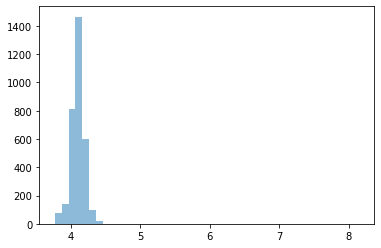

Bin Width: 0.015790072560269926
Num Bins: 45
Max Loss: 4.480663299560547
Min Loss: 3.76609468460083
Min Bin: 3.76609468460083
Max Bin: 8.246757507324219
Optimal Threshold: 4.214160966873168


In [9]:
"""
Utility Functions
"""
# Head tail break function
def htb(data):
    outp = []
    
    def htb_inner(data):
        data_length = float(len(data))
        data_mean = sum(data) / data_length
        
        head = [_ for _ in data if _ > data_mean]
        outp.append(data_mean)
        
        while len(head) > 1 and len(head) / data_length < 0.40:
            return htb_inner(head)
        
    htb_inner(data)
    
    return outp

# Determine a breakpoint
def fetch_threshold(bins, counts, break_point):
    index = 0
    latest_min = 999999
    threshold = -1
    
    for i in range(len(counts)):
        diff = abs(counts[i] - break_point)
        
        if diff <= latest_min:
            latest_min = diff
            index = i
            threshold = ((bins[i + 1] - bins[i]) / 2) + bins[i]
            
    return threshold

predictions = model(x)
targets = x

x_loss = nn.MSELoss(reduction='none')(predictions, targets).sum(axis=1).detach().cpu().numpy().astype(np.float32)

max_loss = np.max(x_loss)
min_loss = np.min(x_loss)

# Compute the optimal bin width using Freedman Diaconis rule
bin_width = 2 * (iqr(x_loss) / (len(x_loss) ** (1./3)))
num_bins = int((max_loss - min_loss) / bin_width)

# Create the histogram
min_bin = np.min(x_loss)
max_bin = np.max(x_loss) + min_bin

step = (max_bin - min_bin) / num_bins

bins = np.arange(min_bin, max_bin, step)

hist, bins = np.histogram(x_loss, bins=bins)

pyplot.hist(x_loss, bins, alpha=0.5)
pyplot.show()

print("Bin Width: {}".format(bin_width))
print("Num Bins: {}".format(num_bins))
print("Max Loss: {}".format(max_loss))
print("Min Loss: {}".format(min_loss))
print("Min Bin: {}".format(min_bin))
print("Max Bin: {}".format(max_bin))



# Determine breaks
breaks = htb(hist)

possible_thresholds = []

for b in breaks:
    t = fetch_threshold(bins, hist, b)
    possible_thresholds.append(t)

optimal_threshold = max(possible_thresholds)

print("Optimal Threshold: {}".format(optimal_threshold))

## Compute for Anomalies

In [10]:
# Convert test data to tensor
x = torch.tensor(df_test_x.values).float().to(device)

predictions = model(x)
targets = x

# Get reconstruction error
x_loss = nn.MSELoss(reduction='none')(predictions, targets).sum(axis=1).detach().cpu().numpy().astype(np.float32)

# If reconstruction error is >= than the optimal threshold, we consider it an anomaly
bool_arr = x_loss >= optimal_threshold

# Convert anomaly labels to -1 if True and 1 if False
anomaly_predictions = np.array([-1 if elem else 1 for elem in bool_arr])

# Build dataframe for test data and attach predictions
df_test_x_with_labels = df_test_x.copy()
df_test_x_with_labels['y'] = anomaly_predictions

df_test_x_with_labels

,x0,x1,x2,x4,x5,x6,x7,x8,x9,x10,...,x13,x14,x15,x16,x17,x18,x19,x20,x21,y
0,0.29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00610,0.0280,0.111,0.131,0.0850,1
1,0.32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00130,0.0190,0.084,0.078,0.1070,1
2,0.35,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00000,0.0310,0.239,0.100,0.2390,1
3,0.21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00100,0.0180,0.087,0.088,0.0990,-1
4,0.22,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0.00040,0.0220,0.134,0.135,0.0990,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3423,0.59,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0.00250,0.0208,0.079,0.099,0.0800,-1
3424,0.51,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.10600,0.0060,0.005,0.089,0.0055,1
3425,0.51,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0.00076,0.0201,0.090,0.067,0.1340,-1
3426,0.35,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00280,0.0201,0.090,0.089,0.1010,1


In [11]:
# # Fit a TSNE model with 3 dimensions
# z_embedded = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(df_test_x_with_labels.drop(columns=['y'], axis=1).values)

# # Create a new data frame for result of tsne and attach cluster label
# df_z_embedded = pd.DataFrame(z_embedded, columns=['x', 'y', 'z'])
# df_z_embedded['y'] = anomaly_predictions

# # Visualize with 3D scatterplot
# fig = px.scatter_3d(df_z_embedded, x='x', y='y', z='z', color='y')
# fig.show()

## Evaluation of Results

In [12]:
ground_truth = np.array([1 if elem == 3 else -1 for elem in df_test_y.values])

y_truth = np.array([0 if elem == -1 else 1 for elem in ground_truth])
y_predictions = np.array([0 if elem == -1 else 1 for elem in anomaly_predictions])

tn, fp, fn, tp = confusion_matrix(ground_truth, anomaly_predictions).ravel()
tn, fp, fn, tp = confusion_matrix(y_truth, y_predictions).ravel()

f1 = tp / (tp + 0.5* (fp + fn))

print("True Positive: {}".format(tp))
print("True Negative: {}".format(tn))
print("False Positive: {}".format(fp))
print("False Negative: {}".format(fn))
print("F1: {}".format(f1))

True Positive: 2808
True Negative: 28
False Positive: 222
False Negative: 370
F1: 0.904639175257732


In [13]:
def predict_proba(y, bool_a, errors, threshold, max_err):
    results = []
    
    for i in range(len(y)):
        if bool_a[i]:
            prob_anomaly = 0.5 + (1 - (threshold / x_loss[i]))
            
            if prob_anomaly > 1:
                prob_anomaly = 0.99
                
            prob_normal = 1 - prob_anomaly
                
            results.append([prob_normal, prob_anomaly])
        else:
            prob_normal = 0.5 + (1 - (x_loss[i] / threshold))
            
            if prob_normal > 1:
                prob_normal = 0.99
            
            prob_anomaly = 1 - prob_normal
            
            results.append([prob_normal, prob_anomaly])
    
    return results

y_probs = predict_proba(y_truth, bool_arr, x_loss, optimal_threshold, np.max(x_loss))

## ROC Curve and AUC

ROC AUC: 0.551827 



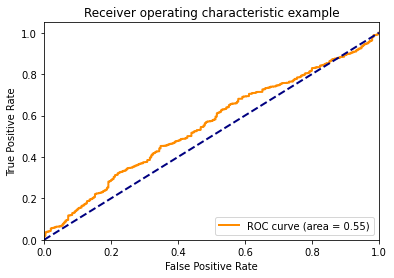

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve

def mapper(arr):
    return arr[0]

probabilities = list(map(mapper, y_probs))
# print(probabilities)

auc = roc_auc_score(y_truth, probabilities)
print('ROC AUC: %f' % auc, '\n')

fpr, tpr, _ = roc_curve(y_truth, probabilities)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()